In [1]:
from rdkit import Chem
from rdkit.Chem import AllChem
import pandas as pd
import matplotlib.pyplot as plt
from hydra import initialize, compose
from pathlib import Path
from collections import defaultdict
import matplotlib.colors
import numpy as np

In [2]:
with initialize(version_base=None, config_path="../configs/filepaths", ):
    filepaths = compose(config_name="filepaths")

In [29]:
Rs = [0, 1, 2, 3, 4]
dts = ['956', '224', '112', '056', '039', '029', '019', '014', '006', '002']
others = ['mechinformed', 'rdchiral', 'imt']
mechinferred_template_sizes = defaultdict(list)
rcr_template_sizes = defaultdict(list)
bad_rules = {'rcr': set(), 'mechinferred': set()}
mechinferred_rules = []
rcr_rules = []
other_rules = []
other_template_sizes = defaultdict(list)

for dt in dts:
    df = pd.read_csv(
        Path(filepaths.processed_data) / f"mechinferred_dt_{dt}_rules.csv",
    )
    mechinferred_rules.append(df)
    for _, row in df.iterrows():
        sma = row["smarts"]
        rxn = AllChem.ReactionFromSmarts(sma)
        mechinferred_template_sizes[dt].append(
            sum(rct.GetNumAtoms() for rct in rxn.GetReactants())
        )

for R in Rs:
    if R == 0:
        df = pd.read_csv(
            Path(filepaths.rules) / "rc_plus_0_rules.csv",
        )
    else:
        df = pd.read_csv(
            Path(filepaths.processed_data) / f"rc_plus_{R}_rules.csv",
        )
    rcr_rules.append(df)
    for _, row in df.iterrows():
        sma = row["smarts"]
        rxn = AllChem.ReactionFromSmarts(sma)
        rcr_template_sizes[R].append(
            sum(rct.GetNumAtoms() for rct in rxn.GetReactants())
        )

for other in others:
    if other == 'imt':
        df = pd.read_csv(
            Path(filepaths.rules) / "imt_rules.csv",
        )
    else:
        df = pd.read_csv(
            Path(filepaths.processed_data) / f"{other}_rules.csv",
        )
    other_rules.append(df)
    for _, row in df.iterrows():
            sma = row["smarts"]
            rxn = AllChem.ReactionFromSmarts(sma)
            other_template_sizes[other].append(
                sum(rct.GetNumAtoms() for rct in rxn.GetReactants())
            )

In [30]:
for dt, df in zip(dts, mechinferred_rules):
    print(f"MechInferred dt = {dt}: {len(df):,} total rules")

print("\n")

for R, df in zip(Rs, rcr_rules):
    print(f"RC + R = {R}: {len(df):,} total rules")

print("\n")
for other, df in zip(others, other_rules):
    print(f"{other}: {len(df):,} total rules")

MechInferred dt = 956: 3,249 total rules
MechInferred dt = 224: 5,579 total rules
MechInferred dt = 112: 7,488 total rules
MechInferred dt = 056: 9,155 total rules
MechInferred dt = 039: 9,924 total rules
MechInferred dt = 029: 10,579 total rules
MechInferred dt = 019: 12,388 total rules
MechInferred dt = 014: 13,360 total rules
MechInferred dt = 006: 15,011 total rules
MechInferred dt = 002: 16,326 total rules


RC + R = 0: 1,032 total rules
RC + R = 1: 6,781 total rules
RC + R = 2: 9,774 total rules
RC + R = 3: 11,664 total rules
RC + R = 4: 12,902 total rules


mechinformed: 899 total rules
rdchiral: 4,919 total rules
imt: 3,597 total rules


In [6]:
mappings = {}
for fp in Path(filepaths.raw_data).glob("mapped_known_reactions*"):
    fn = str(fp.stem).removeprefix("mapped_known_reactions_x_").removesuffix(".parquet")
    mappings[fn] = pd.read_parquet(fp)

In [7]:
krs = pd.read_parquet(Path(filepaths.raw_data) / "known_reactions.parquet")
kes = pd.read_parquet(Path(filepaths.raw_data) / "known_enzymes.parquet")

krs = krs.explode('enzymes')
kes['ec'] = kes['ec'].str.split('; ')
kes = kes.explode('ec')

display(krs.head())
display(kes.head())

,id,smarts,enzymes,reverse,db_ids
0,e908a824c912d1e39c46de92d1f738c92b01fdbd,**.NC(CCC(=O)NC(CS)C(=O)NCC(=O)O)C(=O)O>>*SCC(...,P30109,3bbe8e6dca0da1c745e7678c8efebe14bdbcaaf7,[RHEA:16438]
0,e908a824c912d1e39c46de92d1f738c92b01fdbd,**.NC(CCC(=O)NC(CS)C(=O)NCC(=O)O)C(=O)O>>*SCC(...,P57108,3bbe8e6dca0da1c745e7678c8efebe14bdbcaaf7,[RHEA:16438]
0,e908a824c912d1e39c46de92d1f738c92b01fdbd,**.NC(CCC(=O)NC(CS)C(=O)NCC(=O)O)C(=O)O>>*SCC(...,Q9FE46,3bbe8e6dca0da1c745e7678c8efebe14bdbcaaf7,[RHEA:16438]
0,e908a824c912d1e39c46de92d1f738c92b01fdbd,**.NC(CCC(=O)NC(CS)C(=O)NCC(=O)O)C(=O)O>>*SCC(...,Q9ZVQ4,3bbe8e6dca0da1c745e7678c8efebe14bdbcaaf7,[RHEA:16438]
0,e908a824c912d1e39c46de92d1f738c92b01fdbd,**.NC(CCC(=O)NC(CS)C(=O)NCC(=O)O)C(=O)O>>*SCC(...,P0CG30,3bbe8e6dca0da1c745e7678c8efebe14bdbcaaf7,[RHEA:16438]


,id,sequence,existence,reviewed,ec,organism,name,subunit
0,A0A009IHW8,MSLEQKKGADIISKILQIQNSIGKTTSPSTLKTKLSEISRKEQENA...,Evidence at protein level,reviewed,3.2.2.-,Acinetobacter baumannii (strain 1295743),2' cyclic ADP-D-ribose synthase AbTIR (2'cADPR...,False
0,A0A009IHW8,MSLEQKKGADIISKILQIQNSIGKTTSPSTLKTKLSEISRKEQENA...,Evidence at protein level,reviewed,3.2.2.6,Acinetobacter baumannii (strain 1295743),2' cyclic ADP-D-ribose synthase AbTIR (2'cADPR...,False
1,A0A024B7W1,MKNPKKKSGGFRIVNMLKRGVARVSPFGGLKRLPAGLLLGHGPIRM...,Evidence at protein level,reviewed,2.1.1.56,Zika virus (isolate ZIKV/Human/French Polynesi...,Genome polyprotein [Cleaved into: Capsid prote...,True
1,A0A024B7W1,MKNPKKKSGGFRIVNMLKRGVARVSPFGGLKRLPAGLLLGHGPIRM...,Evidence at protein level,reviewed,2.1.1.57,Zika virus (isolate ZIKV/Human/French Polynesi...,Genome polyprotein [Cleaved into: Capsid prote...,True
1,A0A024B7W1,MKNPKKKSGGFRIVNMLKRGVARVSPFGGLKRLPAGLLLGHGPIRM...,Evidence at protein level,reviewed,2.7.7.48,Zika virus (isolate ZIKV/Human/French Polynesi...,Genome polyprotein [Cleaved into: Capsid prote...,True


In [8]:
_for_ec = ['mechinformed_rules', 'mechinferred_dt_91_rules']
rules_ecs = {}
for elt in _for_ec:
    mapped_krids = mappings[elt]['rxn_id'].unique()
    enzymes = krs.loc[krs['id'].isin(mapped_krids), 'enzymes'].unique()
    tmp = kes.loc[kes['id'].isin(enzymes), 'ec'].unique()
    ecs = []
    for el in tmp:
        if pd.isna(el):
            continue
        ecs.append(tuple(el.split('.')))
    rules_ecs[elt] = ecs
    

Plots

In [9]:
plt.rcParams.update({
    "font.size": 14,
    "axes.labelsize": 14,
    "xtick.labelsize": 14,
    "ytick.labelsize": 14,
    "legend.fontsize": 12,
    "axes.titlesize": 16,
})

colors = {
    'rc_plus_0_rules': matplotlib.colors.to_rgba("black", alpha=0.3),
    'rc_plus_1_rules':matplotlib.colors.to_rgba("black", alpha=0.45),
    'rc_plus_2_rules': matplotlib.colors.to_rgba("black", alpha=0.6),
    'rc_plus_3_rules': matplotlib.colors.to_rgba("black", alpha=0.85),
    'rc_plus_4_rules': matplotlib.colors.to_rgba("black", alpha=1.0),
    'mechinferred_dt_956_rules': matplotlib.colors.to_rgba("purple", alpha=0.3),
    'mechinferred_dt_056_rules': matplotlib.colors.to_rgba("purple", alpha=0.45),
    'mechinferred_dt_014_rules': matplotlib.colors.to_rgba("purple", alpha=0.6),
    'mechinferred_dt_006_rules': matplotlib.colors.to_rgba("purple", alpha=0.85),
    'mechinferred_dt_002_rules': matplotlib.colors.to_rgba("purple", alpha=1.0),
    'mechinformed_rules': matplotlib.colors.to_rgba("green"),
    'rdchiral_rules': matplotlib.colors.to_rgba("blue"),
    'imt_rules': matplotlib.colors.to_rgba("darkorange"),
}

names = {
    'mechinformed_rules': "Mechinformed",
    'rdchiral_rules': "RDChiral",
    'imt_rules': "Pathway-level clustering",
    'mechinferred_dt_956_rules': "Mechinferred >0.956",
    'mechinferred_dt_056_rules': "Mechinferred >0.056",
    'mechinferred_dt_014_rules': "Mechinferred >0.014",
    'mechinferred_dt_006_rules': "Mechinferred >0.006",
    'mechinferred_dt_002_rules': "Mechinferred >0.002",
    'rc_plus_0_rules': "RC + 0",
    'rc_plus_1_rules': "RC + 1",
    'rc_plus_2_rules': "RC + 2",
    'rc_plus_3_rules': "RC + 3",
    'rc_plus_4_rules': "RC + 4",
}

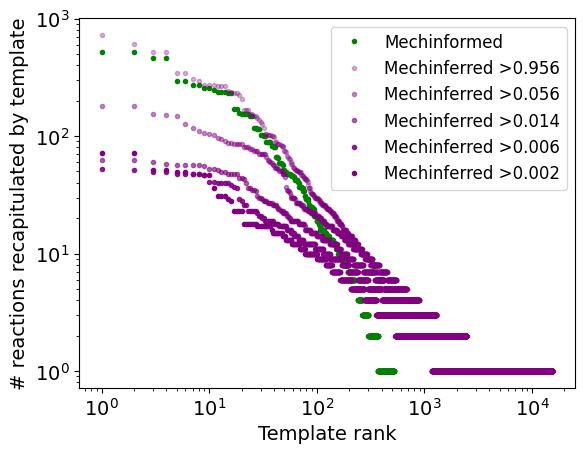

In [10]:
fig, ax = plt.subplots()

for k in names.keys():
    v = mappings[k]
    if "mech" in k:
        cts = v.groupby("rule_id")['rxn_id'].count().sort_values(ascending=False)

        ax.plot(
            range(1, len(cts) + 1),
            cts.values,
            label=names[k],
            color=colors[k],
            marker='.',
            ls='None',
        )

ax.set_yscale("log")
ax.set_xscale("log")
ax.set_xlabel("Template rank")
ax.set_ylabel("# reactions recapitulated by template")
ax.legend()
plt.show()


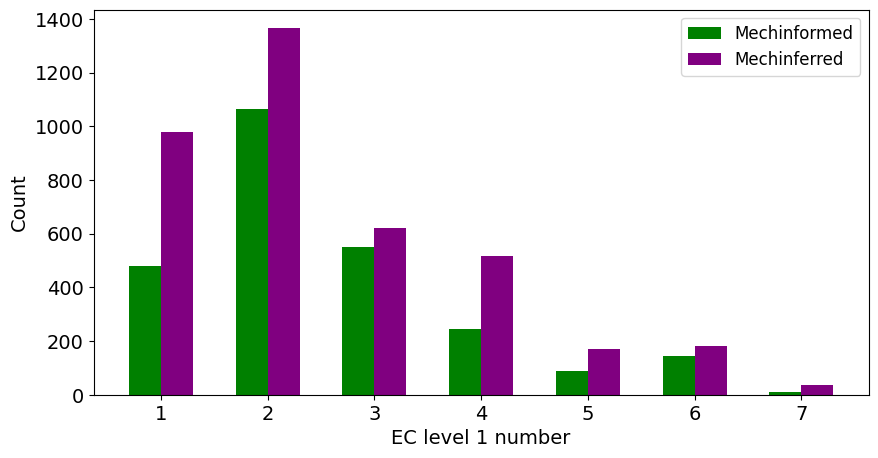

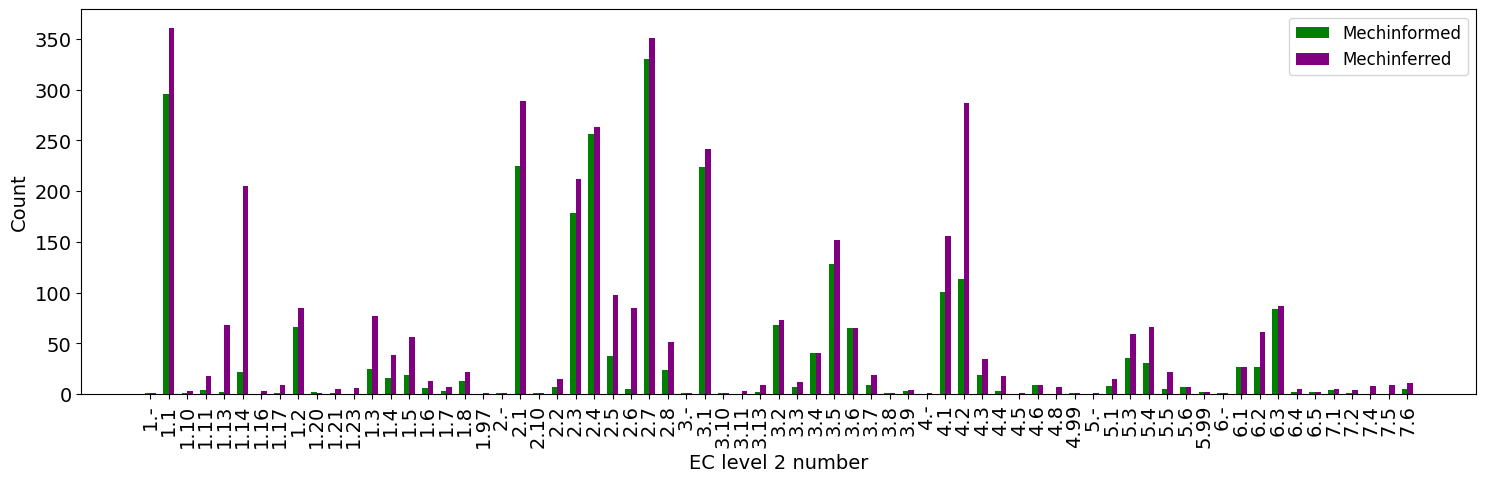

In [11]:
levels = [0, 1]
width = 0.3
figsizes = [
    (10, 5),
    (18, 5),
]
_colors = [
    "green",
    "purple",
]
_labels = [
    "Mechinformed",
    "Mechinferred"
]
rots = [
    0,
    90,
]

for l in levels:
    cts = defaultdict( lambda : defaultdict(int))
    fig, ax = plt.subplots(figsize=figsizes[l])
    for i, k in enumerate(_for_ec):
        for elt in rules_ecs[k]:
            ec = ".".join(elt[:l+1])
            cts[ec][k] += 1

    for i, k in enumerate(_for_ec):
        x_lab, y = zip(*sorted([(ec, cts[ec][k]) for ec in cts.keys()]))
        x = np.arange(len(x_lab))
        ax.bar(x + ((i - 0.5) * 2 * width / 2), y, width, label=_labels[i], color=_colors[i])

    ax.set_xlabel(f"EC level {l+1} number")
    ax.set_ylabel("Count")
    ax.set_xticks(x, x_lab, rotation=rots[l], ha='center')
    ax.legend()
    plt.show()

KeyError: 'mechinferred_dt_224_rules'

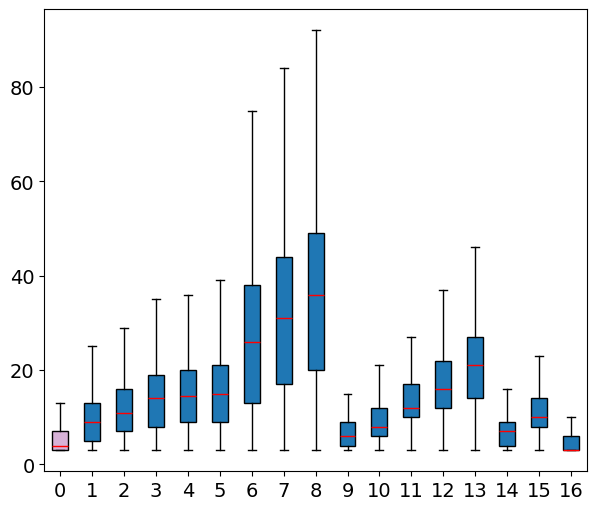

In [27]:
fig, ax = plt.subplots(figsize=(7, 6))
data = []
width = 0.5

for dt, cts in mechinferred_template_sizes.items():
    data.append(cts)
for R, cts in rcr_template_sizes.items():
    data.append(cts)
for other, cts in other_template_sizes.items():
    data.append(cts)

positions = list(range(len(mechinferred_template_sizes) + len(rcr_template_sizes) + len(other_template_sizes)))

bw_plot = ax.boxplot(data, positions=positions, widths=width, patch_artist=True, showfliers=False, medianprops={'color': 'red'})

for path, dt in zip(bw_plot['boxes'], mechinferred_template_sizes.keys()):
    color_key = f"mechinferred_dt_{dt}_rules"
    color = colors[color_key]
    path.set_facecolor(color)

for path, R in zip(bw_plot['boxes'][len(mechinferred_template_sizes):], rcr_template_sizes.keys()):
    color_key = f"rc_plus_{R}_rules"
    color = colors[color_key]
    path.set_facecolor(color)

for path, other in zip(bw_plot['boxes'][len(mechinferred_template_sizes) + len(rcr_template_sizes):], other_template_sizes.keys()):
    color_key = f"{other}_rules"
    color = colors[color_key]
    path.set_facecolor(color)

ax.set_xticks(positions)
xticklabels = [f"Mechinferred >{int(dt)/1e3:.3f}" for dt in dts] + [f"RC + {R}" for R in Rs] + [names[f"{other}_rules"] for other in others]
ax.set_xticklabels(xticklabels, rotation=-75, ha='left')
ax.set_ylabel("Number of atoms in template")
plt.tight_layout()
fig.savefig(Path(filepaths.figures) / "template_size_boxplot.svg", format='svg')
plt.show()

In [31]:
data = []
width = 0.5

def get_row(cts):
    cts = np.array(cts)
    return {
        'min': np.min(cts),
        '25%': np.percentile(cts, 25),
        'median': np.median(cts),
        'mean': np.mean(cts),
        '75%': np.percentile(cts, 75),
        'max': np.max(cts),
    }

for dt, cts in mechinferred_template_sizes.items():
    data.append(
        {'name': f"mechinferred_dt_{dt}_rules", **get_row(cts)}
    )
for R, cts in rcr_template_sizes.items():
    data.append(
        {'name': f"rc_plus_{R}_rules", **get_row(cts)}
    )
for other, cts in other_template_sizes.items():
    data.append(
        {'name': f"{other}_rules", **get_row(cts)}
    )

template_stats = pd.DataFrame(data)
template_stats.to_csv(Path(filepaths.processed_data) / "template_size_stats.csv", index=False)
template_stats.head(20)

,name,min,25%,median,mean,75%,max
0,mechinferred_dt_956_rules,3,3.0,4.0,5.501385,7.0,15
1,mechinferred_dt_224_rules,3,5.0,9.0,9.293601,13.0,30
2,mechinferred_dt_112_rules,3,7.0,11.0,12.484241,16.0,70
3,mechinferred_dt_056_rules,3,8.0,14.0,16.018023,19.0,115
4,mechinferred_dt_039_rules,3,9.0,14.5,17.270657,20.0,133
5,mechinferred_dt_029_rules,3,9.0,15.0,17.891483,21.0,142
6,mechinferred_dt_019_rules,3,12.0,24.0,26.119228,35.0,172
7,mechinferred_dt_014_rules,3,13.0,26.0,28.705389,38.0,182
8,mechinferred_dt_006_rules,3,17.0,31.0,33.407701,44.0,195
9,mechinferred_dt_002_rules,3,20.0,36.0,37.783229,49.0,212


0.05847221240401268